## Микишева Мария Б03-212 Задание Т9

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chi2, kstwobign # Limiting distribution Kolmogorov-Smirnov - асимптотический метод, рекомендованный в scipy
from scipy.special import kolmogorov
from scipy.integrate import quad
from scipy.optimize import minimize
from tqdm import tqdm

import scipy.stats as sps
from scipy import stats
import math
import statistics
from sklearn import preprocessing
import seaborn as sns

In [4]:
m = np.array([5, 8, 6, 12, 14, 18, 11, 6, 13, 7])
N = 100
sample = []
for i in range(0, 10):
  sample.extend([i]*m[i])
sample = np.array(sample)
sample

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9])

In [5]:
borders = np.linspace(0, 9, 10)
borders

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

# a)
H0 - простая гипотеза

## Критерий $\chi^2$

In [6]:
p = np.array([0.1]*10)
np_i = p * N
pd.DataFrame(np.array([p, m, np_i]), columns=np.linspace(0, 9, 10, dtype=int), index=["p_i", "m_i", "np_i"])

,0,1,2,3,4,5,6,7,8,9
p_i,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
m_i,5.0,8.0,6.0,12.0,14.0,18.0,11.0,6.0,13.0,7.0
np_i,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


*Примечание: все np_i и m_i больше 5*

In [10]:
delta = 0
for i in range(10):
  delta += (m[i] - np_i[i])**2 / np_i[i]

print(f'delta_est =  {delta}')

delta_est =  16.4


$\Delta$ ~ $\chi^2$(9)

In [11]:
p_value = 1 - stats.chi2.cdf(delta, 9)
print(f'p_value =  {p_value} > α = 0.05')
print("недостаточно оснований, чтообы отвергнуть гипотезу")

p_value =  0.058984030544419475 > α = 0.05
недостаточно оснований, чтообы отвергнуть гипотезу


## Критерий Колмогорова

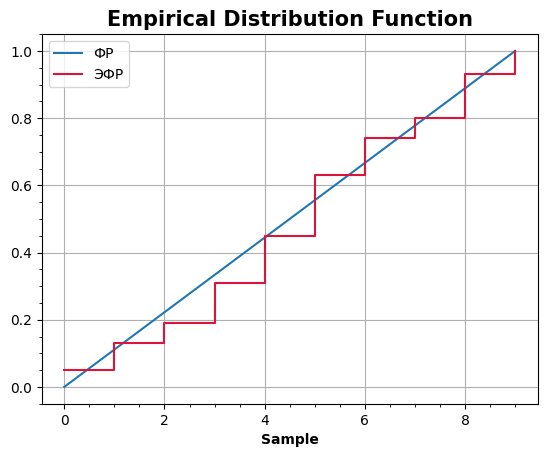

In [12]:
def EDF(sample, ret=False, plot=True):
  prob = np.zeros(len(borders))
  sample = np.sort(sample)
  for t in borders:
    prob[int(t)] = len(sample[sample <= t])/N
  prob[-1] += len(sample[sample > borders[-1]])/N

  if plot == True:
    plt.step(borders, prob, where="post", color="crimson", label="ЭФР")
    plt.minorticks_on()
    plt.grid()

    plt.title('Empirical Distribution Function', fontsize=15,  fontweight='bold')
    plt.xlabel('Sample', fontsize=10, fontweight='bold')
    plt.legend()
    plt.show()
  if ret == True:
    return prob

plt.plot([0, 9], [0, 1], label="ФР")
prob = EDF(sample, ret=True)

Сравниваем отклонение с двух сторон от ФР

In [13]:
def calc_delta(prob, teor_DF, N):
  prob2 = np.copy(prob)
  prob2[1:] = prob[:-1]
  prob2[0] = 0
  return max(max(abs(teor_DF - prob)), max(abs(teor_DF - prob2)))*N**0.5

In [14]:
delta = calc_delta(prob, np.linspace(0, 9, 10) / 9, N)
delta

1.4333333333333331

In [16]:
p_value = 1 - kstwobign.cdf(delta)
print(f'p_value =  {p_value} < α = 0.05')
print("достаточно оснований, чтобы отвергнуть гипотезу")

p_value =  0.032851885438597406 < α = 0.05
достаточно оснований, чтобы отвергнуть гипотезу


**Вывод:** Критерий Колмогорова оказался более чувствительным и выявил несогласие данных с законом равномерного распределения

# b)
H0 - сложная гипотеза (с двумя параметрами)

## Критерий $\chi^2$

### Интервалы

In [17]:
intervals = ["(-inf, 1)", "[1, 2)", "[2, 3)", "[3, 4)", "[4, 5)", "[5, 6)", "[6, 7)", "[7, 8)", "[8, 9)", "[9, +inf)",]
pd.DataFrame(np.array([m]), columns=intervals, index=["m_i"])

,"(-inf, 1)","[1, 2)","[2, 3)","[3, 4)","[4, 5)","[5, 6)","[6, 7)","[7, 8)","[8, 9)","[9, +inf)"
m_i,5,8,6,12,14,18,11,6,13,7


### Оценка параметров максимизацией функции правдоподобия

In [18]:
limits = np.array(-np.inf)
limits = np.append(limits, np.linspace(1, 9, 9))
limits = np.append(limits, np.inf)
limits

array([-inf,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  inf])

In [19]:
def norm(x, mu, sigma):
  return 1/sigma/np.sqrt(2*np.pi) * np.exp(-1/2*((x-mu)/sigma)**2)

In [20]:
def norm_integr(mu, sigma, a, b):
  return quad(norm, a, b, args=(mu, sigma))[0]

In [21]:
norm_integr(0, 1, -np.inf, np.inf)

0.9999999999999997

In [22]:
def L(params, lim, m):
  mu, sigma = params
  L_value = 0.
  for i in range(len(lim)-1):
    L_value -= np.log(norm_integr(mu, sigma, lim[i], lim[i+1]))*m[i]
    #print(L_value)
  return L_value

L([0, 1], limits, m)

1688.8762131006292

In [23]:
initial_guess = [0, 1]
mu, sigma = minimize(L, initial_guess, method="Nelder-Mead", args=(limits, m)).x
mu, sigma

(5.289706214472983, 2.679519798514499)

### Расчет вероятностей попадания в интервалы

In [24]:
def calc_p_i(mu, sigma, lim):
  p = np.zeros(len(m))
  for i in range(len(lim)-1):
    p[i] = norm_integr(mu, sigma, lim[i], lim[i+1])
  return p

p = calc_p_i(mu, sigma, limits)
p

array([0.05469693, 0.05507868, 0.08663255, 0.11873642, 0.14180619,
       0.14757628, 0.13382844, 0.10575231, 0.07281797, 0.08307424])

In [25]:
np_i = p * N
intervals = ["(-inf, 1)", "[1, 2)", "[2, 3)", "[3, 4)", "[4, 5)", "[5, 6)", "[6, 7)", "[7, 8)", "[8, 9)", "[9, +inf)",]
pd.DataFrame(np.array([m, np_i]), columns=intervals, index=["m_i", "np_i"])

,"(-inf, 1)","[1, 2)","[2, 3)","[3, 4)","[4, 5)","[5, 6)","[6, 7)","[7, 8)","[8, 9)","[9, +inf)"
m_i,5.000000,8.000000,6.000000,12.000000,14.000000,18.000000,11.000000,6.000000,13.000000,7.000000
np_i,5.469693,5.507868,8.663255,11.873642,14.180619,14.757628,13.382844,10.575231,7.281797,8.307424


### Оценка p_value

In [26]:
delta = 0
for i in range(len(m)):
  delta += (m[i] - np_i[i])**2 / np_i[i]

delta

9.80249937945015

$\Delta$ ~ $\chi^2$(10-1-2)

In [28]:
p_value = 1 - stats.chi2.cdf(delta, 7)
print(f'p_value =  {p_value} > α = 0.05')
print("недостаточно оснований, чтообы отвергнуть гипотезу")

p_value =  0.2000446578669305 > α = 0.05
недостаточно оснований, чтообы отвергнуть гипотезу


## Критерий Колмогорова
Применим т.к. распределение непрерывное

### Оценка параметров по выборке

In [29]:
def norm_dist_params(sample):
  mean = np.mean(sample)
  return mean, np.sqrt(N/(N-1) * np.mean( (sample-mean)**2 ))

_mu, _sigma = norm_dist_params(sample)
_mu, _sigma

(4.77, 2.5180359509953494)

### Теоретическая функция распределения

In [30]:
def calc_teor_DF(_mu_i, _sigma_i):
  norm_f = np.array([])
  for t in borders:
      norm_f = np.append(norm_f, norm_integr(_mu_i, _sigma_i, -np.inf, t))
  return norm_f
norm_f = calc_teor_DF(_mu, _sigma)
norm_f

array([0.02909037, 0.06717079, 0.13565218, 0.24105006, 0.37988079,
       0.53638919, 0.68739362, 0.81208637, 0.90020942, 0.95350974])

### Сравнение ЭФР и теоретической ФР

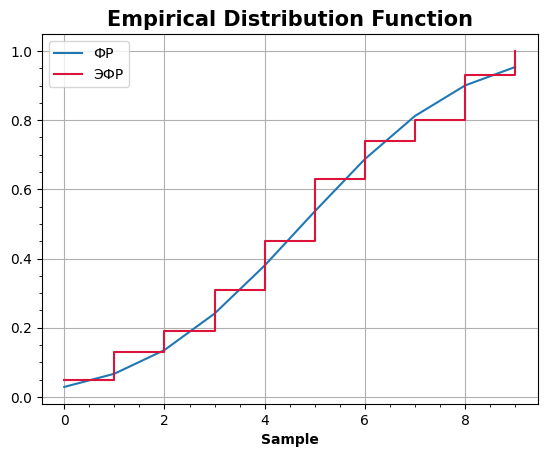

In [31]:
plt.plot(np.arange(0,10), norm_f, label="ФР")
prob = EDF(sample, ret=True)

$\Delta$ по исходной выборке

In [32]:
delta = calc_delta(prob, norm_f, N)
delta

1.0020942299329105

### Вычисление $\Delta_i$ бутстрапом

In [96]:
bootstrap_length = 50000
delta_bt = np.zeros(bootstrap_length)
_mu, _sigma = norm_dist_params(sample)

for i in tqdm(range(bootstrap_length)):
  sample_i = np.random.normal(_mu, _sigma, N)
  _mu_i, _sigma_i = norm_dist_params(sample_i)
  norm_f_i = calc_teor_DF(_mu_i, _sigma_i)
  prob_i = EDF(sample_i, ret=True, plot=False)
  delta_bt[i] = calc_delta(prob_i, norm_f_i, N)

delta_bt

100%|████████████████████████████████████| 50000/50000 [02:29<00:00, 335.50it/s]


array([1.90776112, 2.3142024 , 2.03938291, ..., 1.61331542, 1.61932182,
       1.68172506])

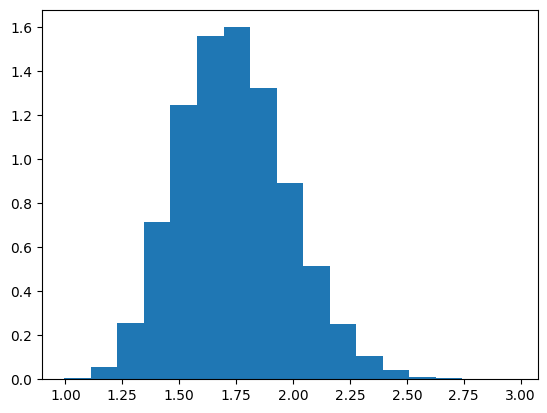

In [97]:
k = 1 + int(round(np.log2(len(delta_bt))))
plt.hist(delta_bt, density=True, bins=k);

In [98]:
min(delta_bt)

0.9958651698823695

In [99]:
delta_bt.sort()
delta_bt

array([0.99586517, 1.02511421, 1.03085728, ..., 2.84552006, 2.90993887,
       2.97642138])

In [100]:
sum(delta_bt < delta)

1

In [102]:
k = sum(delta_bt < delta)
k += 1

p_value = 1 - (k - 1)/bootstrap_length
print(f'p_value =  {p_value} > α = 0.05')

p_value =  0.99998 > α = 0.05


Недостаточно оснований, чтобы отвергнуть гипотезу

**Вывод:** оба критерия показали согласованность данных с нормальным распределением